<a href="https://colab.research.google.com/github/Caroline-511/Brain_tumor_detection_using_Machine-learning_and_Image-processing-/blob/main/Small_Datasets_VGG_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [2]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

.
├── drive
│   └── MyDrive
│       ├── 6th_sem_projects
│       ├── aug
│       │   ├── no
│       │   └── yes
│       ├── aug_new_datsets
│       │   ├── no
│       │   │   └── no
│       │   └── yes
│       │       └── yes
│       ├── brain_tumor_dataset
│       │   ├── no
│       │   └── yes
│       ├── Cc
│       ├── Classroom
│       │   └── V A- Compiler Design A
│       ├── Crafts
│       ├── DAA 
│       ├── Downloads 
│       ├── Food-Time lapse video
│       ├── Java
│       ├── Keyboard
│       ├── Keyboard audio
│       ├── logs
│       │   └── brain_tumor_detection_cnn_1623231333
│       │       ├── train
│       │       │   └── plugins
│       │       │       └── profile
│       │       │           ├── 2021_06_09_09_35_35
│       │       │           ├── 2021_06_09_10_04_15
│       │       │           ├── 2021_06_09_10_12_55
│       │       │           ├── 2021_06_09_10_21_36
│       │       │           └── 2021_06_09_10_30_16
│       │       └── validation
│       ├── Ma

In [5]:
IMG_PATH = '/content/drive/MyDrive/brain_tumor_dataset'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + '/'+CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + '/'+CLASS)):
            img = IMG_PATH + '/' + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
                
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [6]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [7]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00,  4.36it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

100%|██████████| 2/2 [00:00<00:00, 14.32it/s]

193 images loaded from TRAIN/ directory.
10 images loaded from TEST/ directory.
50 images loaded from VAL/ directory.


In [8]:
from matplotlib import pyplot
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline


y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

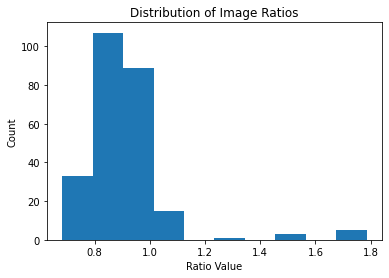

In [9]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [10]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [11]:
img = cv2.imread('/content/drive/MyDrive/brain_tumor_dataset/yes/Y1.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()


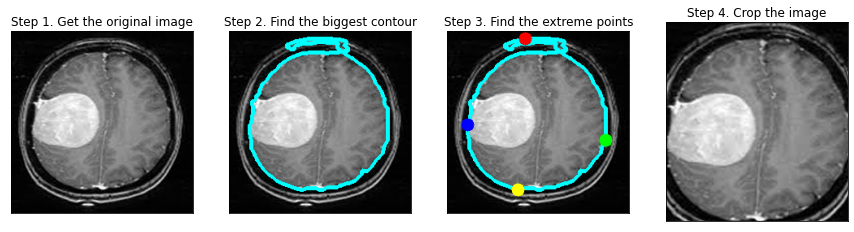

In [12]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()


In [13]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [14]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [15]:
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [16]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [17]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [18]:
# set the paramters we want to change randomly
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator

demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

for img in os.listdir('TRAIN_CROP/YES'): 
  img = cv2.cv2.imread('TRAIN_CROP/YES/' + img)
  x = img_to_array(img)
  x = x.reshape((1,) + x.shape) 

  i = 0
  for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='TRAIN_CROP/YES', save_prefix='aug_', save_format='jpg'):
      i += 1
      if i > 20:
          break 




In [19]:
for img1 in os.listdir('TRAIN_CROP/NO'): 
  img = cv2.cv2.imread('TRAIN_CROP/NO/' + img1)
  x = img_to_array(img)
  x = x.reshape((1,) + x.shape) 

  i = 0
  for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='TRAIN_CROP/NO', save_prefix='aug_', save_format='jpg'):
      i += 1
      if i > 20:
          break 

In [20]:
for img1 in os.listdir('VAL_CROP/YES'): 
  img = cv2.cv2.imread('VAL_CROP/YES/' + img1)
  x = img_to_array(img)
  x = x.reshape((1,) + x.shape) 

  i = 0
  for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='VAL_CROP/YES', save_prefix='aug_', save_format='jpg'):
      i += 1
      if i > 20:
          break 

for img1 in os.listdir('VAL_CROP/NO'): 
  img = cv2.cv2.imread('VAL_CROP/NO/' + img1)
  x = img_to_array(img)
  x = x.reshape((1,) + x.shape) 

  i = 0
  for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='VAL_CROP/NO', save_prefix='aug_', save_format='jpg'):
      i += 1
      if i > 20:
          break 

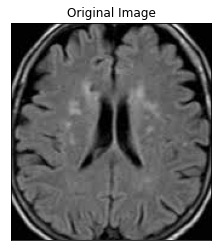

In [21]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()


In [22]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 3834 images belonging to 2 classes.
Found 1069 images belonging to 2 classes.


In [23]:
print ("number of training examples = " + str(X_train_crop.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
#print ("number of test examples = " + str(X_preview.shape[0]))

number of training examples = 193
number of development examples = 50


In [24]:
# load base model
base_model = VGG16(
    weights='imagenet',
    include_top=False, 
  input_shape=IMG_SIZE + (3,)
)

58900480/58889256 [==============================] - 0s 0us/step


In [25]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [26]:
EPOCHS = 5
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)
history = model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

Epoch 1/5
50/50 [==============================] - 80s 638ms/step - loss: 4.4672 - accuracy: 0.6086 - val_loss: 0.7905 - val_accuracy: 0.8225
Epoch 2/5
50/50 [==============================] - 24s 475ms/step - loss: 3.2680 - accuracy: 0.6850 - val_loss: 0.9943 - val_accuracy: 0.8375
Epoch 3/5
50/50 [==============================] - 24s 478ms/step - loss: 2.8269 - accuracy: 0.7413 - val_loss: 0.8523 - val_accuracy: 0.8650
Epoch 4/5
50/50 [==============================] - 24s 477ms/step - loss: 2.2125 - accuracy: 0.7721 - val_loss: 1.1192 - val_accuracy: 0.8325
Epoch 5/5
50/50 [==============================] - 24s 473ms/step - loss: 2.2137 - accuracy: 0.8023 - val_loss: 1.1638 - val_accuracy: 0.8500


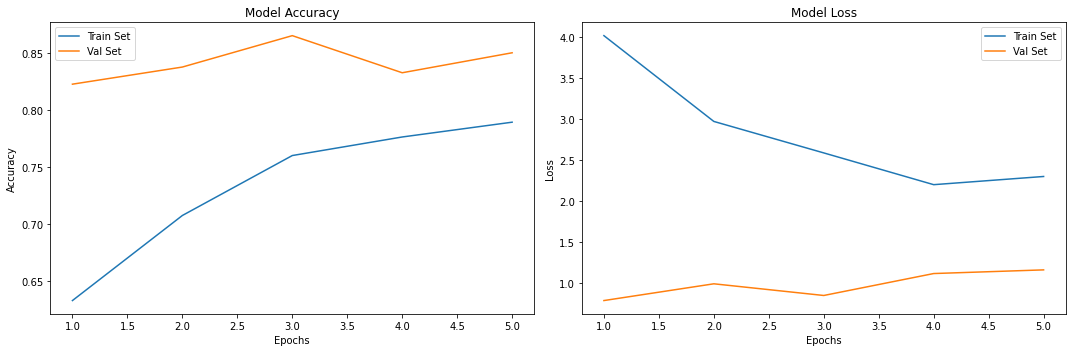

In [27]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [28]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

Val Accuracy = 0.88


In [29]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy1 = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy1)

Test Accuracy = 0.80


In [ ]:
from keras.models import load_model
from keras.preprocessing import image
model.save('vggclf.h5')
model=load_model("vggclf.h5")
img = image.load_img('/content/drive/MyDrive/new_datasets/no/image(1).jpg',target_size=(224,224))
img=np.asarray(img)
plt.imshow(img)
img=np.expand_dims(img,axis=0)
pred = model.predict(img)
print(pred[0][0])

In [30]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [31]:
y_test_prob = model.predict(X_test_prep)

In [32]:
f1score = compute_f1_score(y_test , y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.8333333333333333


In [33]:
print('Val Accuracy = %.2f' % accuracy)
print('Test Accuracy = %.2f' % accuracy1)

Val Accuracy = 0.88
Test Accuracy = 0.80


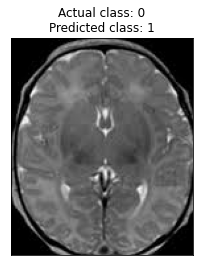

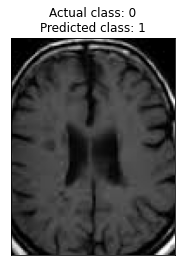

In [34]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()